In this tutorial, we are going to demonstrate how to combine STARNet-inferred Gene Regulatory Networks with drug response mapping to identify region-specific drug response patterns.

Kanemaru, K., Cranley, J., Muraro, D. et al. Spatially resolved multiomics of human cardiac niches. Nature 619, 801–810 (2023). https://doi.org/10.1038/s41586-023-06311-1

In [94]:
import pickle as pkl
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib_venn import venn2
from adjustText import adjust_text
from tqdm import tqdm
import drug2cell as d2c
import scanpy as sc
import blitzgsea as blitz
import anndata
import sys
import scipy as sp
import seaborn as sns
import STARNet as ST
sys.path.append("/home/zhangxuting/workspace/STmultiGRN/GoogleDrive/network")
from network_utils import *
from utils import *

# Set figure parameters for Scanpy
sc.settings.set_figure_params(dpi=120)

### Import Data

First, we load either our provided dataset or your trained mouse embryo spatial transcriptomics data.

In [36]:
# load expression
adata = sc.read_h5ad('../GoogleDrive/Mouse_Embryo/Process_Data/tmp_fig7_rna.h5ad')
adata_origin = adata.copy()

Here, we convert gene names from mouse to human due to limitations in the Drug2Cell database. We then annotate the spatial domains of the embryo and visualize it.

[<Axes: title={'center': 'spatial domain'}, xlabel='spatial1', ylabel='spatial2'>]

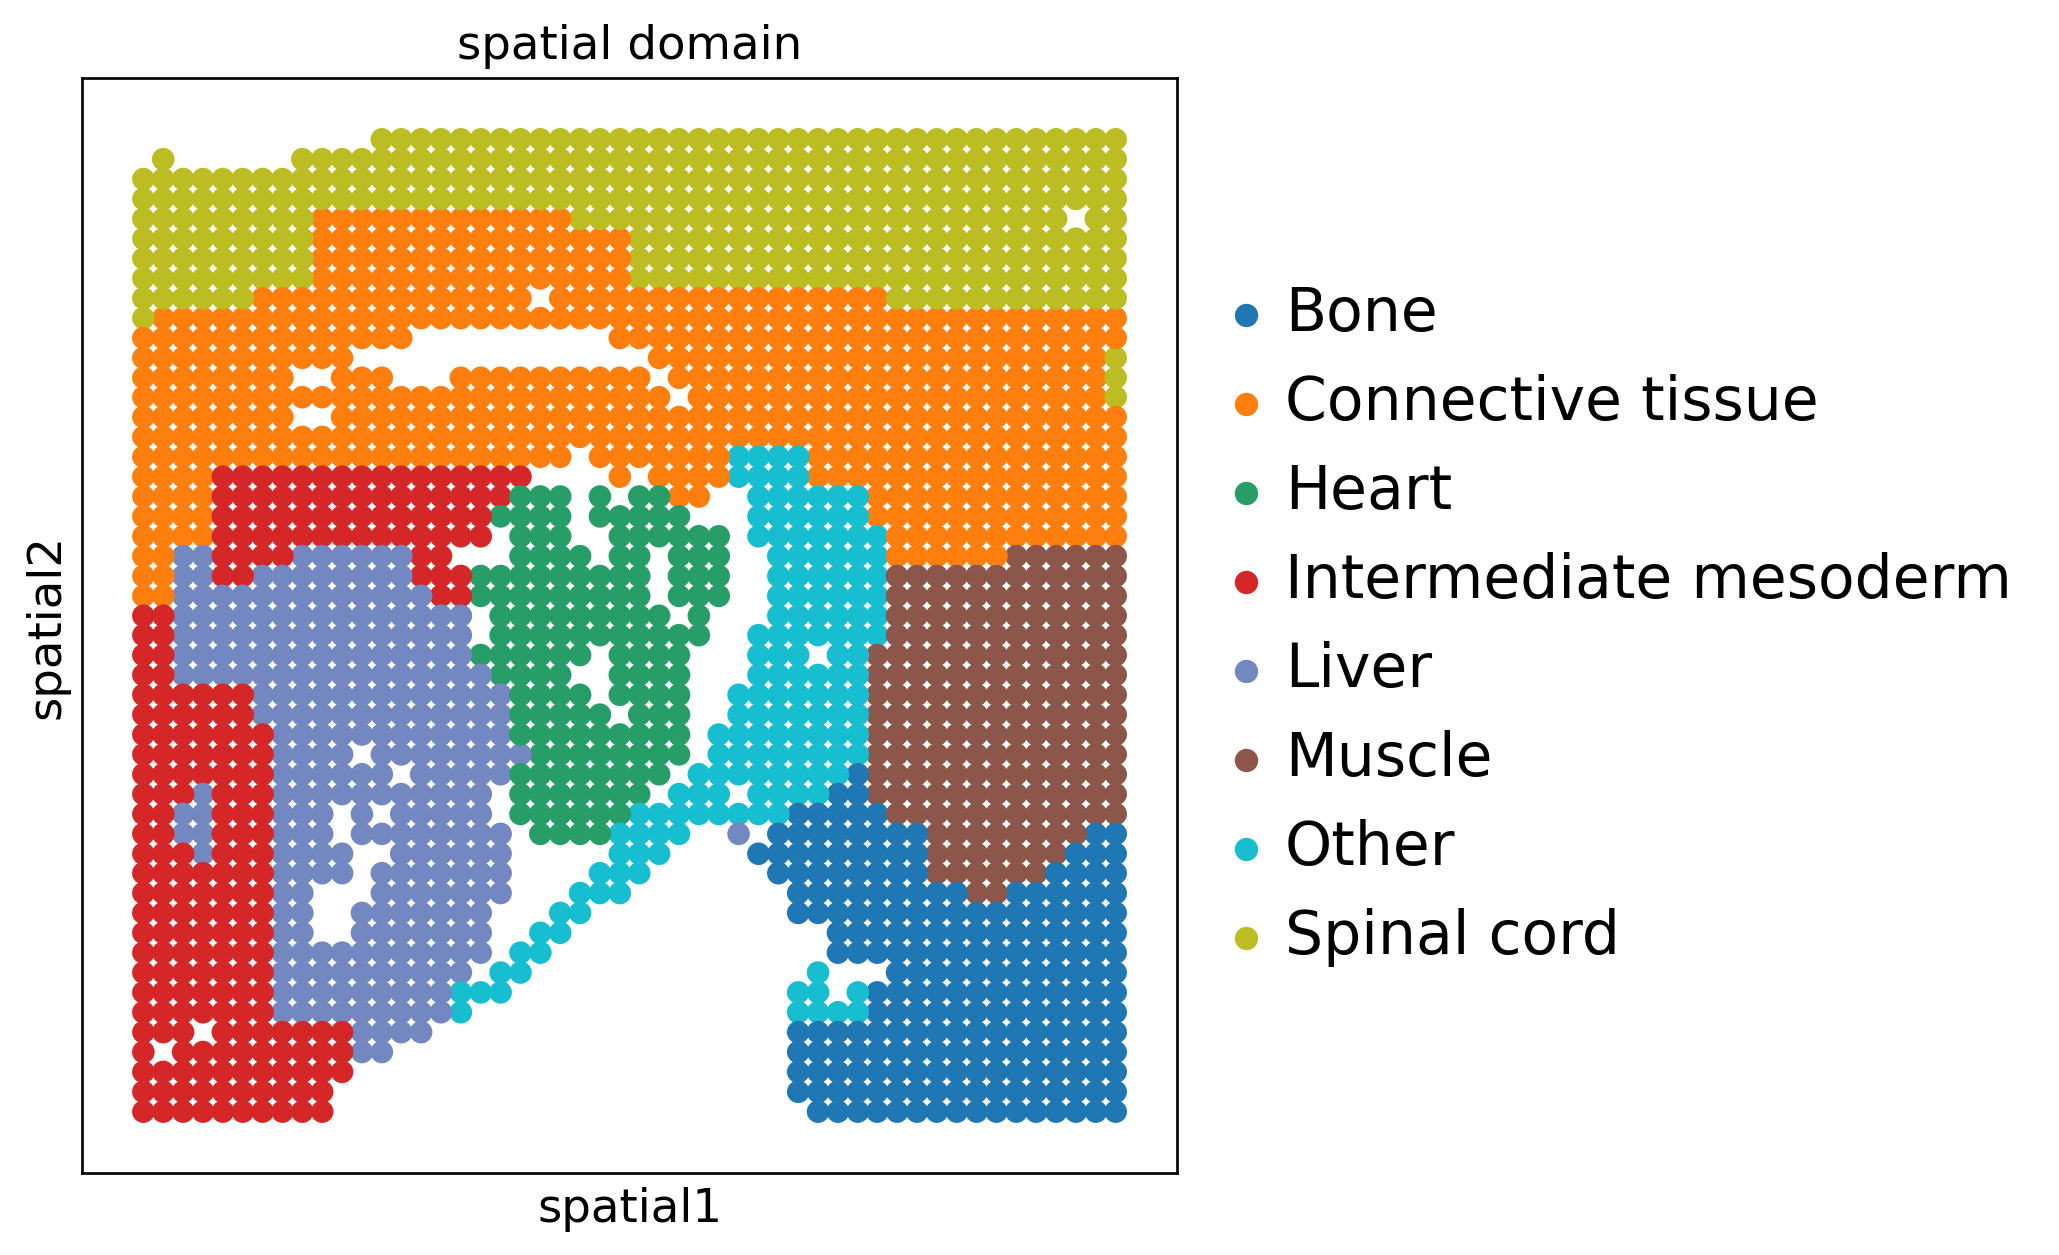

In [37]:
adata.var_names = [transfer_gene_name(gene, direction='m2h') for gene in adata.var_names.to_list()]
if adata.raw is not None:
    adata.raw._var.index = [transfer_gene_name(gene, direction='m2h') for gene in adata.raw.var_names.to_list()]

cluster2annotation = {
    '0': 'Spinal cord',
    '1': 'Connective tissue',
    '2': 'Muscle',
    '3': 'Bone',
    '4': 'Other',
    '5': 'Liver',
    '6': 'Connective tissue',
    '7': 'Heart',
    '8': 'Intermediate mesoderm', 
}

adata.uns['spatial domain_colors'] = [
    '#1f77b4',  # Spinal cord
    '#ff7f0e',  # Connective tissue
    '#279e68',  # Muscle
    '#d62728',  # Bone
    '#7388c1',  # Other
    '#8c564b',  # Liver
    '#17becf',  # Heart
    '#bcbd22'   # Intermediate mesoderm
]

adata.obs['spatial domain'] = adata.obs['leiden'].map(cluster2annotation).astype('category')

# Plot spatial data
fig, ax = plt.subplots(figsize=(6, 6))
sc.pl.spatial(adata, color='spatial domain', spot_size=50, 
			  legend_fontsize=18, ax=ax, show=False, frameon=None)

### TF Calculation

Next, we'll load the GRN data containing TF and target gene information. We'll convert all TF and gene names to uppercase to conform to the drug2cell database requirements.

In [38]:
# load grn
grn_adata = sc.read_h5ad("../GoogleDrive/Mouse_Embryo/Process_Data/fig7_grn_nlog10_pval.adata")
grn_adata.var_names = grn_adata.var_names.str.upper()

if grn_adata.raw is not None:
    grn_adata.raw._var.index = grn_adata.raw.var_names.str.upper()
    
tf_gene_df = adata.uns['grn_df']
tf_gene_df["TF"] = tf_gene_df["TF"].str.upper()
tf_gene_df["target gene"] = tf_gene_df["target gene"].str.upper()
tf_target_dict = tf_gene_df.groupby('TF')['target gene'].apply(list).to_dict()

Next, we calculate TF enrichment for each region using the Cauchy combination test. Higher scores indicate greater TF importance within specific spatial regions.

In [ ]:
# tf enrichment
adata.uns['grn'] = {}
adata.uns['grn']['adata_nlog10_pval'] = grn_adata.T

tf_enrich_df = cal_cauchy_combination_test(adata,annotation_col='spatial domain')
tf_enrich_df = tf_enrich_df.apply(pd.to_numeric, errors='coerce')
tf_enrich_df = tf_enrich_df.apply(lambda x: x.fillna(0))

Now, we load the drug-target information provided in Google Drive. Using `d2c.score()`, we obtain drug scores that represent the average target gene expression level in each spot. We then analyze the differential expression of these drug scores across spatial domains to identify which drugs show higher expression in specific regions.

### Drug Calculation

In [ ]:
# load drug
raw_drug_target_dict = pkl.load(open("../GoogleDrive/drug2Cell/drug-target_dicts.pkl", "rb"))
drug_target_dict = {}
for key, dt_dict in raw_drug_target_dict.items():
    drug_target_dict.update(dt_dict)

In [41]:
# d2C: all drug target
d2c.score(adata, use_raw=True)
sc.tl.rank_genes_groups(adata.uns['drug2cell'], method="wilcoxon", groupby="spatial domain")
adata.uns["drug2cell_all"] = adata.uns["drug2cell"]
adata.uns['drug2cell_all'].obsm['X_umap'] = adata.uns['drug2cell_all'].obsm['X_spatial'] * [1, -1]

... storing 'genes' as categorical
... storing 'all_genes' as categorical


Here we are going to find the overlap target gene between the drug-target and the TF-target. If the number of genes in the intersection exceeds a threshold, then this pair of "drug-TF" and their common target genes will be stored in a new dictionary called `enriched_dict`. This dictionary represents the most interesting "drug-TF" combinations with potential interactions.

`min_overlap_threshold` defines the minimum number of shared target genes required for a drug–transcription factor (TF) pair to be considered potentially associated.
If a drug and a TF share fewer than 2 target genes, the pair is excluded from further analysis.

`min_foldchange` sets the log-fold change threshold used in the final differential analysis.
Only drug–TF pairs with an absolute log-fold change greater than or equal to 1 will be considered significant and retained for downstream interpretation.

In [42]:
# d2C: drug && TF targets overlap
min_overlap_threshold = 2
min_foldchange = 1

dt_overlap_dict = {}
for drug, drug_genes in tqdm(drug_target_dict.items()):
    drug_gene_set = set(drug_genes)
    for tf, tf_genes in tf_target_dict.items():
        tf_gene_set = set(tf_genes)
        overlap = drug_gene_set & tf_gene_set
        if overlap:
            key = f"{drug}_{tf}"
            dt_overlap_dict[key] = list(overlap)
count_list = []
enriched_dict = {}
for key, value in dt_overlap_dict.items():
    count_list.append(len(value))
    if len(value) > min_overlap_threshold:
        enriched_dict[key] = value
d2c.score(adata, use_raw=True,targets=enriched_dict)
adata.uns['drug2cell'].obsm['X_umap'] = adata.uns['drug2cell'].obsm['X_spatial'] * [1, -1]
sc.tl.rank_genes_groups(adata.uns['drug2cell'], method="wilcoxon", groupby="spatial domain")





























100%|██████████| 2447/2447 [00:02<00:00, 889.83it/s]
... storing 'genes' as categorical
... storing 'all_genes' as categorical


### Get Drug-TF Target result

In [43]:
# get enriched drug-tf targets
deg_df = get_ranked_genes_df(adata.uns['drug2cell'].uns["rank_genes_groups"], n_genes=10)
high_deg_df = deg_df[abs(deg_df['logfoldchanges']) > min_foldchange].copy()
overlap_gene_num_list = [len(dt_overlap_dict[i]) for i in high_deg_df["drug"].tolist()]
high_deg_df["overlap_gene_num"] = overlap_gene_num_list

drug_all_target_deg_df = get_ranked_genes_df(adata.uns['drug2cell_all'].uns["rank_genes_groups"], n_genes=50)
drug_all_target_deg_df = drug_all_target_deg_df[drug_all_target_deg_df["pvals_adj"]<0.05]

In [44]:
# get enriched drug-tf targets
deg_df = get_ranked_genes_df(adata.uns['drug2cell'].uns["rank_genes_groups"], n_genes=10)
high_deg_df = deg_df[abs(deg_df['logfoldchanges']) > min_foldchange].copy()
overlap_gene_num_list = [len(dt_overlap_dict[i]) for i in high_deg_df["drug"].tolist()]
high_deg_df["overlap_gene_num"] = overlap_gene_num_list

drug_all_target_deg_df = get_ranked_genes_df(adata.uns['drug2cell_all'].uns["rank_genes_groups"], n_genes=50)
drug_all_target_deg_df = drug_all_target_deg_df[drug_all_target_deg_df["pvals_adj"]<0.05]

# find candidate
drug_tf_list = high_deg_df["drug"].tolist()
hd_drug_list = list(set([i.split("_")[0] for i in drug_tf_list]))

hc_tf_list  = [i.split("_")[1] for i in drug_tf_list]
hc_drug_list = [i.split("_")[0] for i in drug_tf_list]

overlap_gene_num_list = [len(dt_overlap_dict[i]) for i in high_deg_df["drug"].tolist()]
high_deg_df["overlap_gene_num"] = overlap_gene_num_list

idx_of_interest = []
for idx, row in high_deg_df.iterrows():
    drug_tf = row["drug"]
    drug, tf = drug_tf.split("_")
    enriched_region = row["group"]
    overlap_genes = dt_overlap_dict[drug_tf]
    all_targets_enriched_region = list(set(drug_all_target_deg_df[drug_all_target_deg_df["drug"]==drug]["group"].tolist()))
    tf_enrich = tf_enrich_df.loc[tf]
    tf_enrich_region = tf_enrich[tf_enrich > 1.3].index.tolist()

    if len(all_targets_enriched_region) == 0 or enriched_region not in all_targets_enriched_region or tf_enrich_region == [] or enriched_region not in tf_enrich_region:
        print(f"Drug {drug} does not have targets in enriched region {enriched_region}. Skipping...")
        continue
    
    idx_of_interest.append(idx)
    
    print("-"*50 + f"{idx}" + "-"*50)
    print(f"Drug: {drug}, TF: {tf}")
    print(f"Overlap genes: {overlap_genes}")
    print(f"Overlap genes Enriched region: {enriched_region}")
    print(f"All targets enriched region: {all_targets_enriched_region}")
    print(f"TF enrichment region: {tf_enrich_region}")

Drug CHEMBL24828|VANDETANIB does not have targets in enriched region Bone. Skipping...
Drug CHEMBL539770|TERODILINE HYDROCHLORIDE does not have targets in enriched region Liver. Skipping...
Drug CHEMBL1059|PREGABALIN does not have targets in enriched region Liver. Skipping...
Drug CHEMBL1628502|GABAPENTIN ENACARBIL does not have targets in enriched region Liver. Skipping...
Drug CHEMBL2095222|OCRIPLASMIN does not have targets in enriched region Muscle. Skipping...
Drug CHEMBL2108709|COLLAGENASE CLOSTRIDIUM HISTOLYTICUM does not have targets in enriched region Muscle. Skipping...
Drug CHEMBL2095222|OCRIPLASMIN does not have targets in enriched region Muscle. Skipping...
Drug CHEMBL2095222|OCRIPLASMIN does not have targets in enriched region Muscle. Skipping...
--------------------------------------------------55--------------------------------------------------
Drug: CHEMBL451887|CARFILZOMIB, TF: ZFP637
Overlap genes: ['PSMC3', 'PSMD12', 'PSMD7']
Overlap genes Enriched region: Muscle
Al

Finally, we can search for specific target genes of interest within our results and extract them for further downstream analysis.

In [45]:
# Search for specific genes/drugs in high_deg_df and print indices
search_term = 'HOXB6'

matching_indices = []
for idx, row in high_deg_df.iterrows():
	if search_term in row['drug']:
		matching_indices.append(idx)

if matching_indices:
	print(f"Indices containing '{search_term}': {matching_indices}, {high_deg_df.loc[matching_indices, 'drug'].tolist()}")
else:
	print(f"No matches found for '{search_term}'")

Indices containing 'HOXB6': [70], ['CHEMBL220492|TOPIRAMATE_HOXB6']


In [46]:
idx_hoxb6 = 70
row_of_interest = high_deg_df.loc[idx_hoxb6, :]
print(row_of_interest)
drug_tf = row_of_interest["drug"]
drug, tf = drug_tf.split("_")
overlap_genes = dt_overlap_dict[drug_tf]
print(f"Overlap genes: {overlap_genes}")

drug                CHEMBL220492|TOPIRAMATE_HOXB6
group                                 Spinal cord
logfoldchanges                           2.291796
pvals_adj                                     0.0
overlap_gene_num                                6
Name: 70, dtype: object
Overlap genes: ['SCN1A', 'GRIA4', 'SCN3A', 'GABRG2', 'GRIK2', 'GRIK3']


### Spatial Enrichment

Now we visualize the target gene of a specific TF and drug, and their overlapping genes.

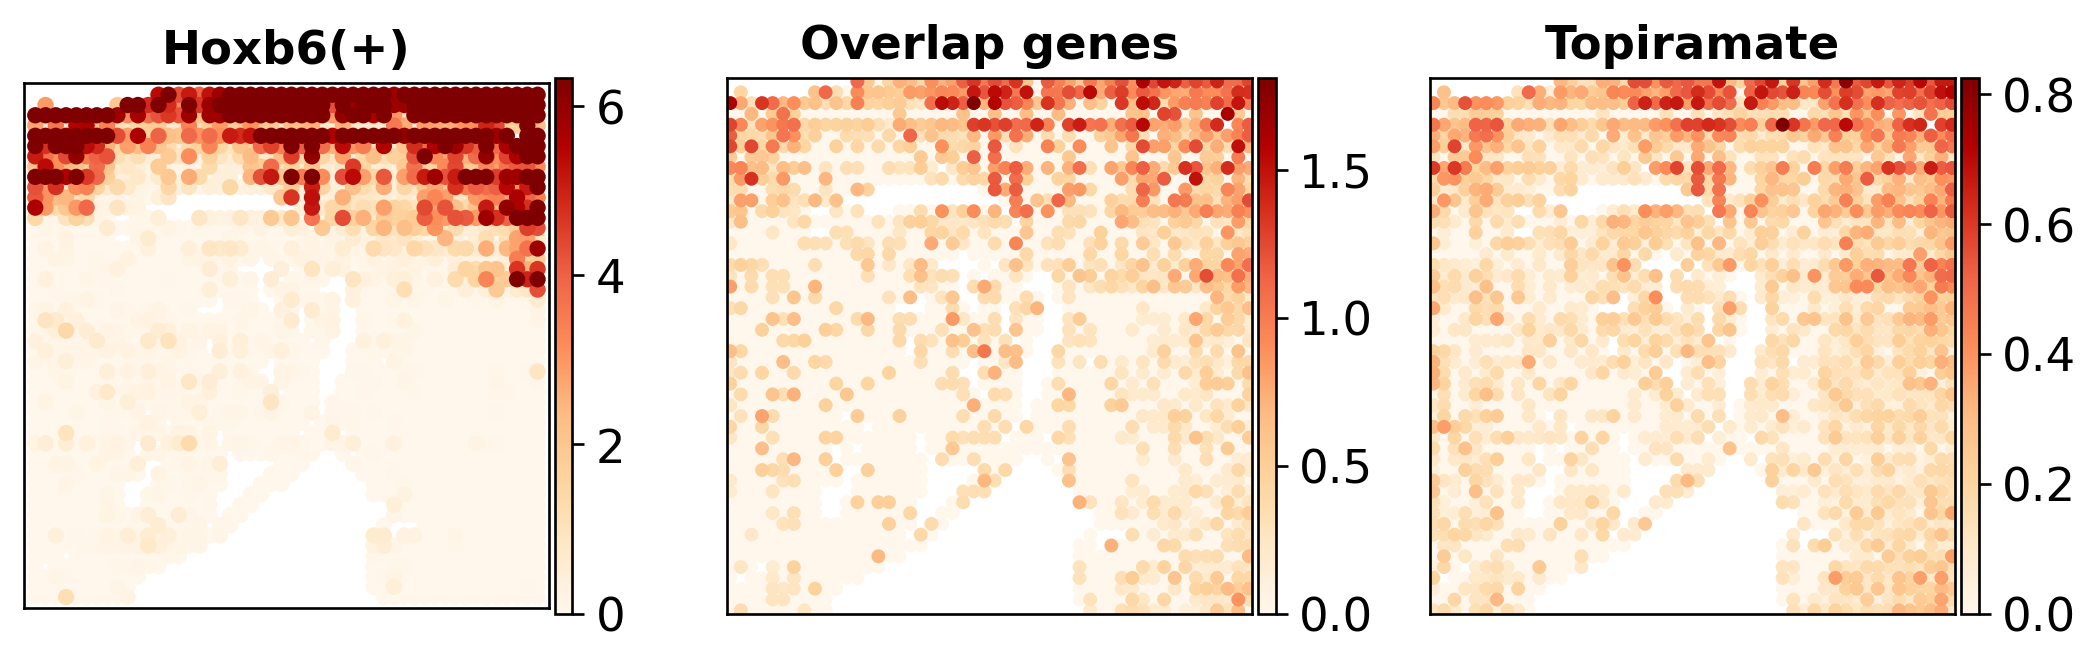

In [47]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3))

# Plot configurations
plots = [
	(grn_adata, tf, transfer_gene_name(tf, direction='h2m')+"(+)", 'spatial'),
	(adata.uns['drug2cell'], drug_tf, "Overlap genes", 'umap'),
	(adata.uns['drug2cell_all'], drug, drug.split("|")[1].capitalize(), 'umap')
]

for i, (data, color_var, title, plot_type) in enumerate(plots):
	if plot_type == 'spatial':
		sc.pl.spatial(data, color=color_var, spot_size=70, ax=axes[i], 
					  show=False, color_map="OrRd")
	else:
		sc.pl.umap(data, color=color_var, size=70, ax=axes[i], 
				   show=False, color_map="OrRd")
	
	axes[i].set_title(title, fontsize=14, fontweight='bold')
	
	# Adjust axis limits
	xmin, xmax = axes[i].get_xlim()
	ymin, ymax = axes[i].get_ylim()
	margin = 0.04
	axes[i].set_xlim(xmin + margin*(xmax-xmin), xmax - margin*(xmax-xmin))
	axes[i].set_ylim(ymin + margin*(ymax-ymin), ymax - margin*(ymax-ymin))
	axes[i].set_xlabel('', fontsize=12)
	axes[i].set_ylabel('', fontsize=12)

plt.tight_layout()
plt.show()


### Target overlap network

Also, we can plot a network to visualize how the two networks interact with each other.

In [50]:
adata_origin.uns['grn'] = {}
adata_origin.uns['grn']['adata_nlog10_pval'] = grn_adata.T

hox_grn_weight = {}
TF_list = ['Hoxb6']
for TF_id in TF_list:
    print(f'Calculate the GRN weight of {TF_id}.')
    hox_grn_weight[TF_id] = ST.pp.grn_weight(adata_origin, tf_gene=TF_id,n_jobs=10)

Calculate the GRN weight of Hoxb6.


/data/CondaEnv/STARNet_env/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/data/CondaEnv/STARNet_env/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/data/CondaEnv/STARNet_env/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to

Identify 498 spots with Hoxb6 GRN pval<0.05.


100%|██████████| 139/139 [05:19<00:00,  2.30s/it]


In [51]:
ranked_keys = sorted(hox_grn_weight["Hoxb6"].keys(), key=lambda x: hox_grn_weight["Hoxb6"][x], reverse=True)
goi_list =  ['GRIK3', 'GRIA4', 'SCN1A', 'GABRG2', 'SCN3A', 'GRIK2']
goi_list = [i.capitalize() for i in goi_list]
goi_rank_list = [ranked_keys.index(i) for i in goi_list if i in ranked_keys]

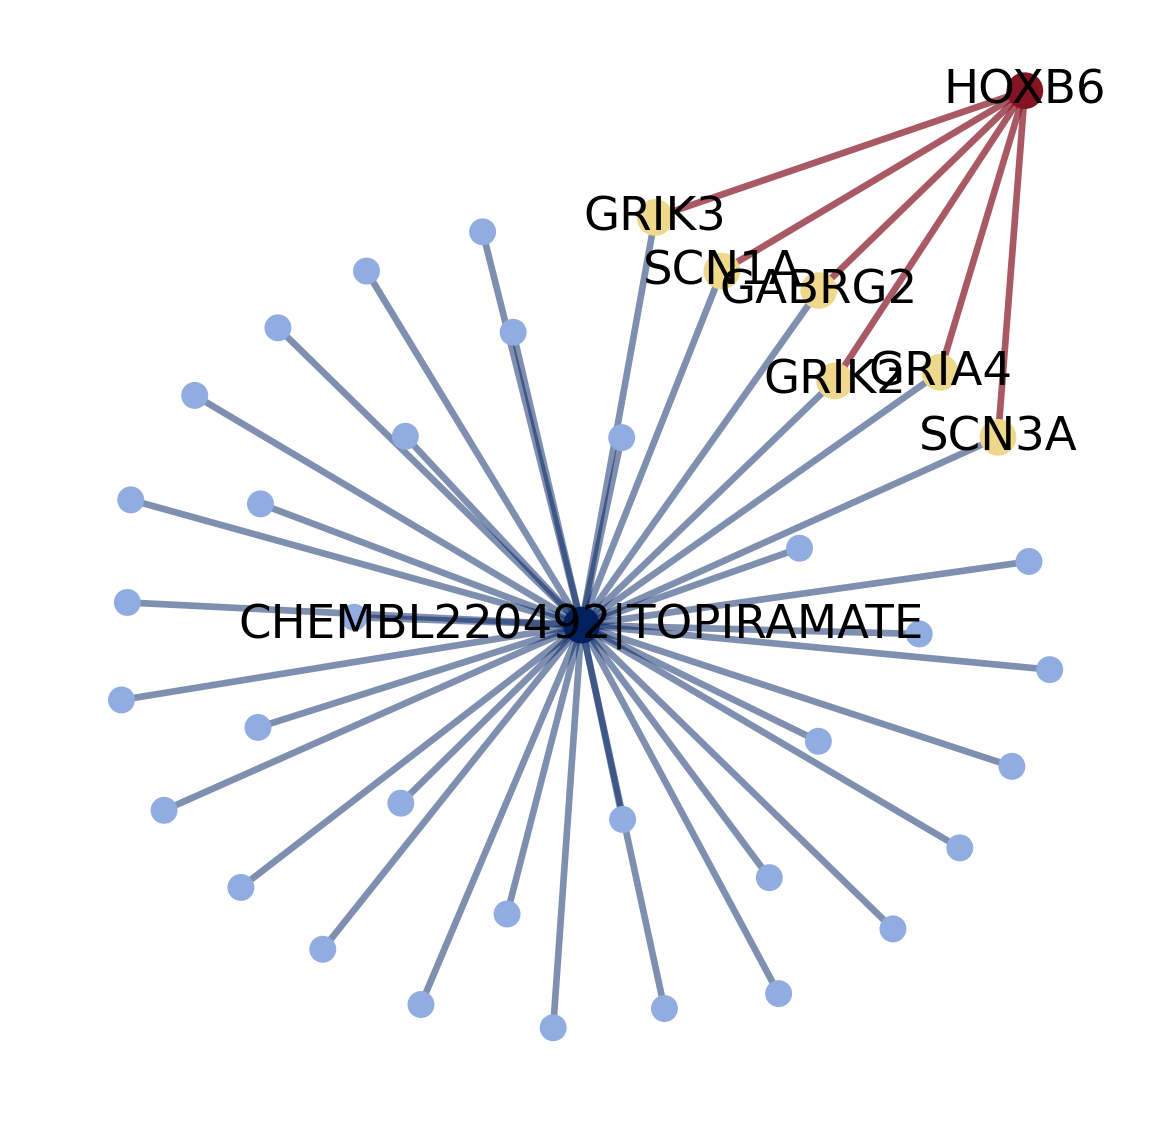

In [53]:
fig, ax = drug_tf_network_new(drug_target_dict, tf_target_dict, dt_overlap_dict, 
                            drug_tf_pair=[drug_tf],
                            pos_type="kamada_kawai",
                            # pos_type="spring",
                            pos_scale=15,
                            node_alpha=1,
                            figsize=(6, 6),
                            if_overlap_only=True,
                    )
plt.show()

In [54]:
drug, tf = drug_tf.split("_")
drug_targets = set(drug_target_dict[drug])
tf_targets = set(tf_target_dict[tf])
overlap_genes = dt_overlap_dict[drug_tf]
print(f"Drug: {drug}, TF: {tf}")
print(f"Drug targets: {drug_targets}")
print(f"TF targets: {tf_targets}")
print(f"Overlap genes: {overlap_genes}")

Drug: CHEMBL220492|TOPIRAMATE, TF: HOXB6
Drug targets: {'GABRG1', 'SCN3A', 'GABRA6', 'GABRB3', 'GABRA3', 'GABRD', 'GRIK5', 'GABRP', 'GRIK1', 'CA1', 'SCN4A', 'SCN10A', 'GRIK2', 'GABRA2', 'GRIK3', 'GRIK4', 'SCN1A', 'GABRE', 'GRIA4', 'SCN2A', 'GABRA1', 'SCN5A', 'SCN7A', 'CA4', 'SCN9A', 'GABRQ', 'GRIA2', 'CA2', 'GABRB2', 'GABRG2', 'GRIA3', 'GABRA5', 'SCN11A', 'GRIA1', 'GABRB1', 'GABRA4', 'GABRG3', 'SCN8A'}
TF targets: {'STK32A', 'RBFOX1', 'MAGI2', 'SCN3A', 'ENC1', 'BCL11B', 'NCAN', 'LSAMP', 'GM3764', 'TUBB2B', 'CMIP', 'GAD2', 'CNTNAP2', 'UNC79', 'TUBB3', 'ARHGAP20', 'DNM3', 'TRIM9', 'ST8SIA2', 'GRIK2', 'NTRK3', 'HOXB3', 'NTN1', 'FAM171B', 'TMEM130', 'SCG3', 'FAM227A', 'DMXL2', 'LHFPL4', 'STMN2', 'ACAP3', 'NRXN3', 'LINGO1', 'SLC43A2', 'HOXB8', 'ABAT', 'PDE10A', 'NEFL', 'KIF21B', 'DPP6', 'SPTBN2', 'CELSR3', 'DPF3', 'KCNQ2', 'DPYSL3', 'SPON1', 'RNF165', 'PFKP', 'SRRM4', 'INA', 'NRXN2', 'BSN', 'SCN1A', 'SYT4', 'DCC', 'PTPRT', 'ROBO3', 'KIF3C', 'PLEKHA6', 'CADM3', 'ADRA1A', 'GRIN2B', 'PLCB1', '

### Pathway Enrichment

We run an enrichment analysis to see what biological jobs three different gene lists are involved in. We test the genes targeted by both the drug and the TF, then all of the TF's targets, and finally all of the drug's targets. Comparing the functions of these three groups shows us how the drug might be working.

In [62]:
import omicverse as ov

In [57]:
ov.utils.download_pathway_database()

......Pathway Geneset download start: GO_Biological_Process_2021
......Downloading dataset save to genesets/GO_Biological_Process_2021.txt
......Creating directory genesets
......[GO_Biological_Process_2021 Size of file]: 0.15 MB
......[Downloader]: >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>100.00%
.......Finish！62.384910583496094.2f s
......Pathway Geneset download start: GO_Cellular_Component_2021
......Downloading dataset save to genesets/GO_Cellular_Component_2021.txt
......[GO_Cellular_Component_2021 Size of file]: 0.03 MB
......[Downloader]: >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>100.00%
.......Finish！2.5183908939361572.2f s
......Pathway Geneset download start: GO_Molecular_Function_2021
......Downloading dataset save to genesets/GO_Molecular_Function_2021.txt
......[GO_Molecular_Function_2021 Size of file]: 0.03 MB
......[Downloader]: >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>100.00%
.......Finish！6.595326662063599.2f s
......Pathway Geneset download 

In [63]:
pathway_dict=ov.utils.geneset_prepare('genesets/GO_Biological_Process_2021.txt',organism='Mouse')
overlap_genes_mouse = transfer_gene_name(overlap_genes, direction='h2m')
enr = ov.bulk.geneset_enrichment(gene_list=overlap_genes_mouse,pathways_dict=pathway_dict,pvalue_type='auto',organism='Mouse')

In [64]:
tf_targets = list(tf_targets)
drug_targets = list(drug_targets)

In [66]:
tf_targets_mouse = transfer_gene_name(tf_targets, direction='h2m')
drug_targets_mouse = transfer_gene_name(drug_targets, direction='h2m')
enr_tf = ov.bulk.geneset_enrichment(gene_list=tf_targets_mouse,pathways_dict=pathway_dict,pvalue_type='auto',organism='Mouse')
enr_drug = ov.bulk.geneset_enrichment(gene_list=drug_targets_mouse,pathways_dict=pathway_dict,pvalue_type='auto',organism='Mouse')

In [67]:
enr_tf

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Genes,logp,logc,num,fraction
29,CUSTOM140446108369472,acidic amino acid transport (GO:0015800),2/17,2.993314e-03,3.501768e-02,29.945139,Slc1a2;Slc6a1,3.351902,3.399367,2,0.117647
34,CUSTOM140446108369472,action potential (GO:0001508),3/44,1.256422e-03,1.916043e-02,16.596711,Scn3a;Chrna4;Scn1a,3.954908,2.809205,3,0.068182
51,CUSTOM140446108369472,anterior/posterior pattern specification (GO:0...,3/59,2.926065e-03,3.501768e-02,12.405905,Hoxb9;Hoxb3;Basp1,3.351902,2.518173,3,0.050847
53,CUSTOM140446108369472,anterograde trans-synaptic signaling (GO:0098916),14/229,6.349054e-12,2.711046e-09,14.461536,Grik2;Slc6a1;Slc1a2;Kcnq2;Gria4;Gabrg2;Grin2b;...,19.725931,2.671492,14,0.061135
59,CUSTOM140446108369472,axon choice point recognition (GO:0016198),2/5,2.286075e-04,5.137653e-03,95.321466,Gap43;Robo3,5.271159,4.557255,2,0.400000
...,...,...,...,...,...,...,...,...,...,...,...
809,CUSTOM140446108369472,sodium ion transport (GO:0006814),4/87,8.440639e-04,1.386213e-02,10.918941,Atp1b1;Scn3a;Slc6a1;Scn1a,4.278595,2.390499,4,0.045977
827,CUSTOM140446108369472,synapse assembly (GO:0007416),4/67,3.130586e-04,6.855180e-03,14.164479,Nrxn2;Gabrg2;Dnm3;Dner,4.982751,2.650737,4,0.059701
828,CUSTOM140446108369472,synapse organization (GO:0050808),6/125,3.292098e-05,1.171438e-03,11.153332,L1cam;Slc6a1;Cntn2;Dnm3;Nrxn2;Dner,6.749523,2.411738,6,0.048000
831,CUSTOM140446108369472,"synaptic transmission, glutamatergic (GO:0035249)",2/18,3.356874e-03,3.675347e-02,28.325455,Grik3;Grik2,3.303523,3.343761,2,0.111111


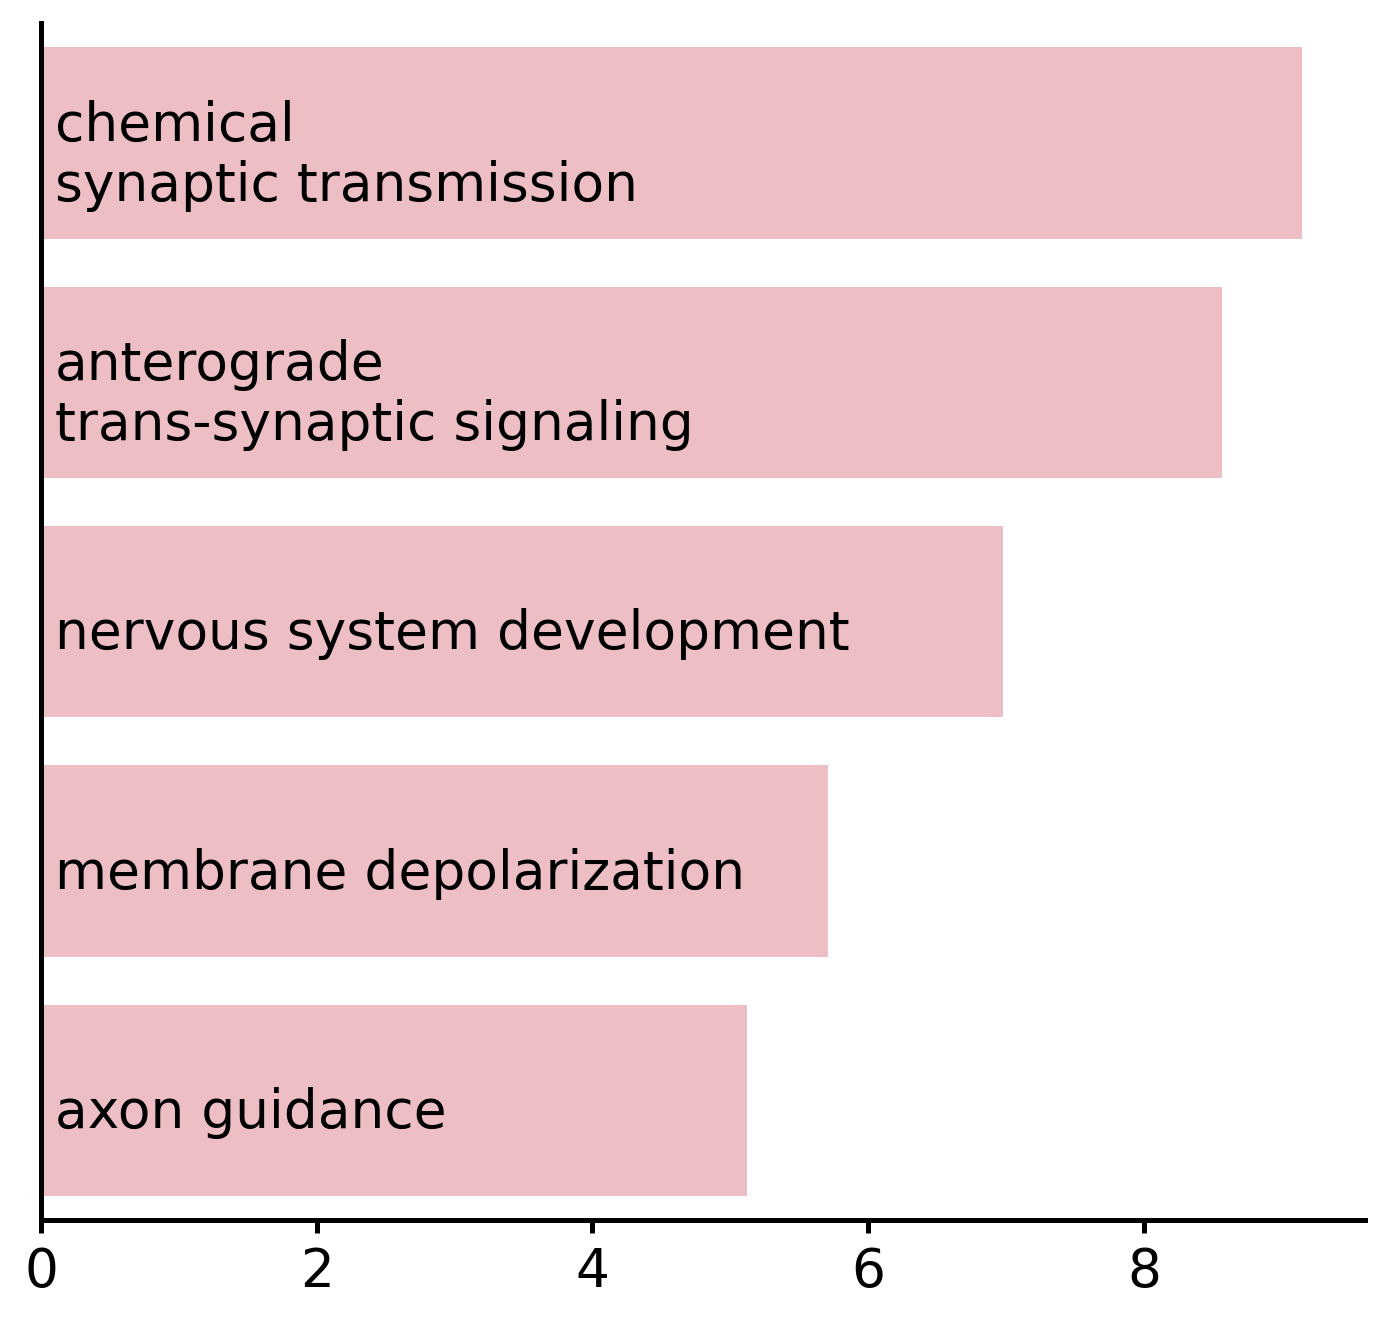

In [72]:
enr_tf = enr_tf.sort_values(['Adjusted P-value'],ascending=True)
enr_tf_plot = enr_tf[:5]

fig,ax = ST.pl.pathway_enrichment(enr_tf_plot,color='#F5B7BF', threshold=30,fontsize=16,
								  title='')

ax.set_xlabel('',fontsize=16,)
plt.grid(False)
ax.tick_params(axis='x', which='major', labelsize=16, width=1.5, length=4,direction='out')
ax.tick_params(axis='y', which='major', labelsize=16, width=1.5, length=0,direction='out')

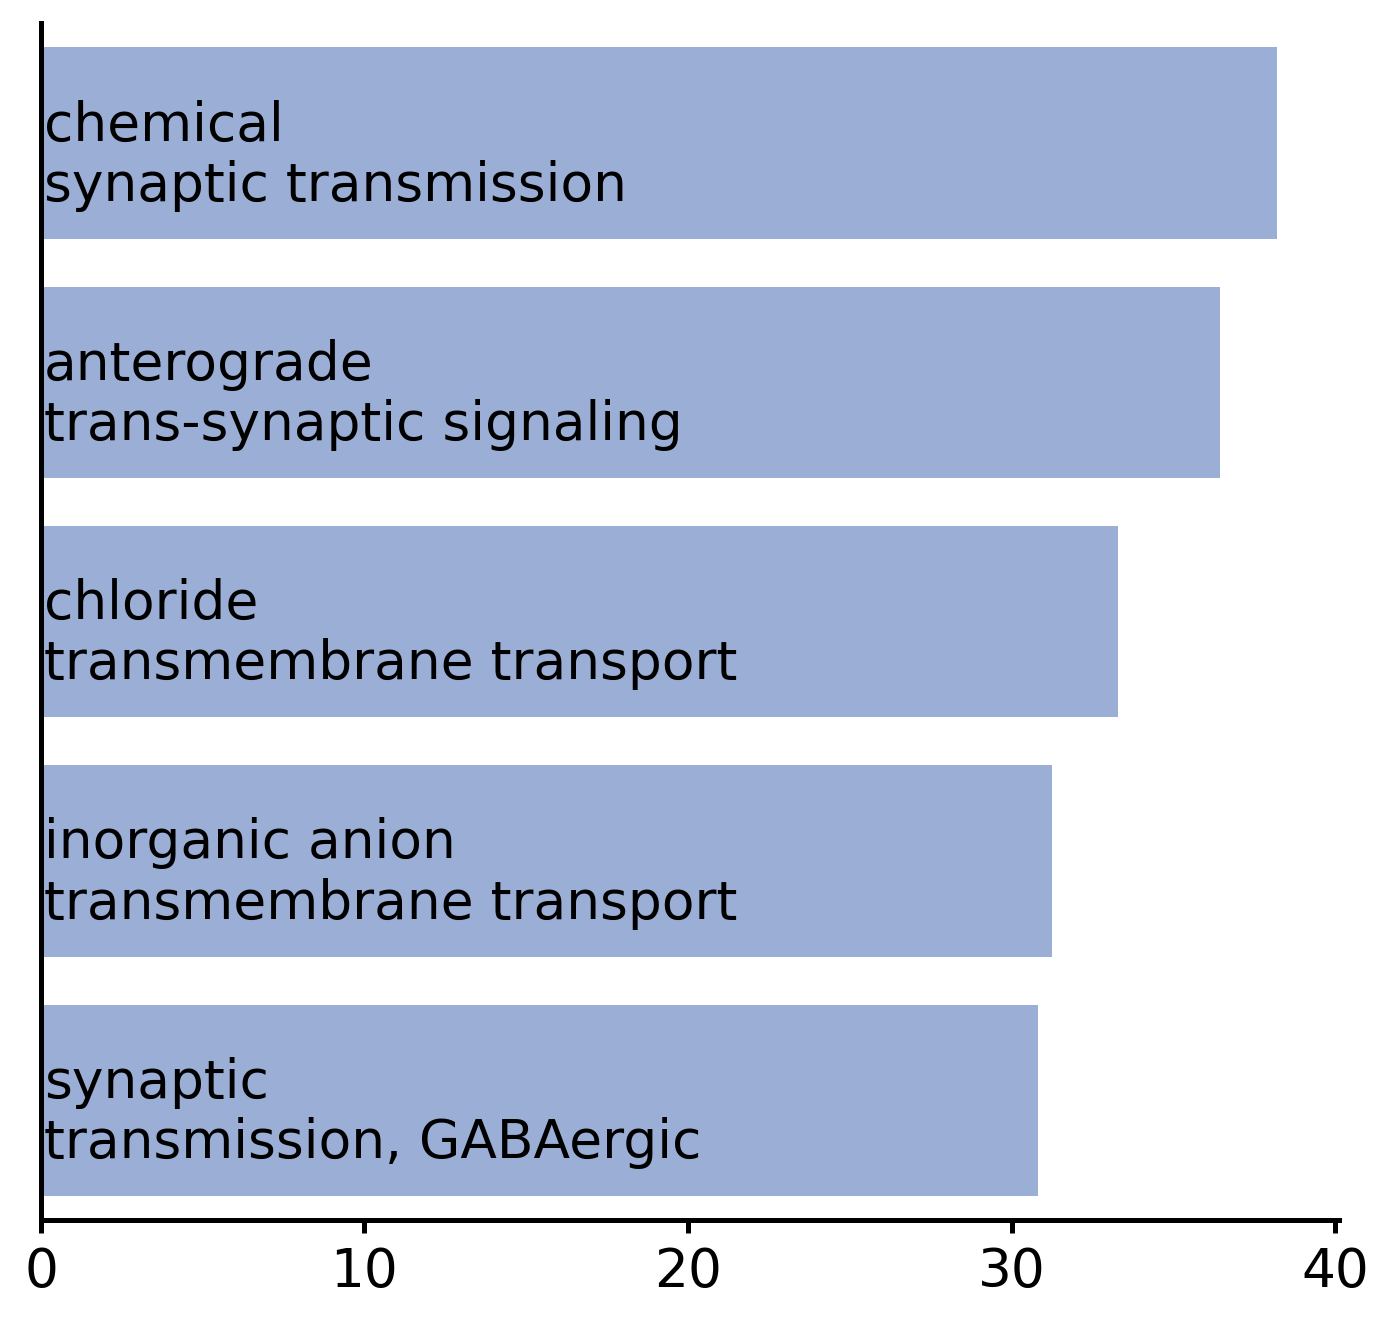

In [73]:
enr_drug = enr_drug.sort_values(['Adjusted P-value'],ascending=True)
enr_drug_plot = enr_drug[:5]

fig,ax = ST.pl.pathway_enrichment(enr_drug_plot,color='#91ACE0', threshold=30,fontsize=16,
								  title='')

ax.set_xlabel('',fontsize=16,)
plt.grid(False)
ax.tick_params(axis='x', which='major', labelsize=16, width=1.5, length=4,direction='out')
ax.tick_params(axis='y', which='major', labelsize=16, width=1.5, length=0,direction='out')

### Heatmap

Here, we first run a test to find which drugs are most active in each spatial region. Then, we create a heatmap to visualize the results, showing us which drugs are most statistically significant in the spinal cord.

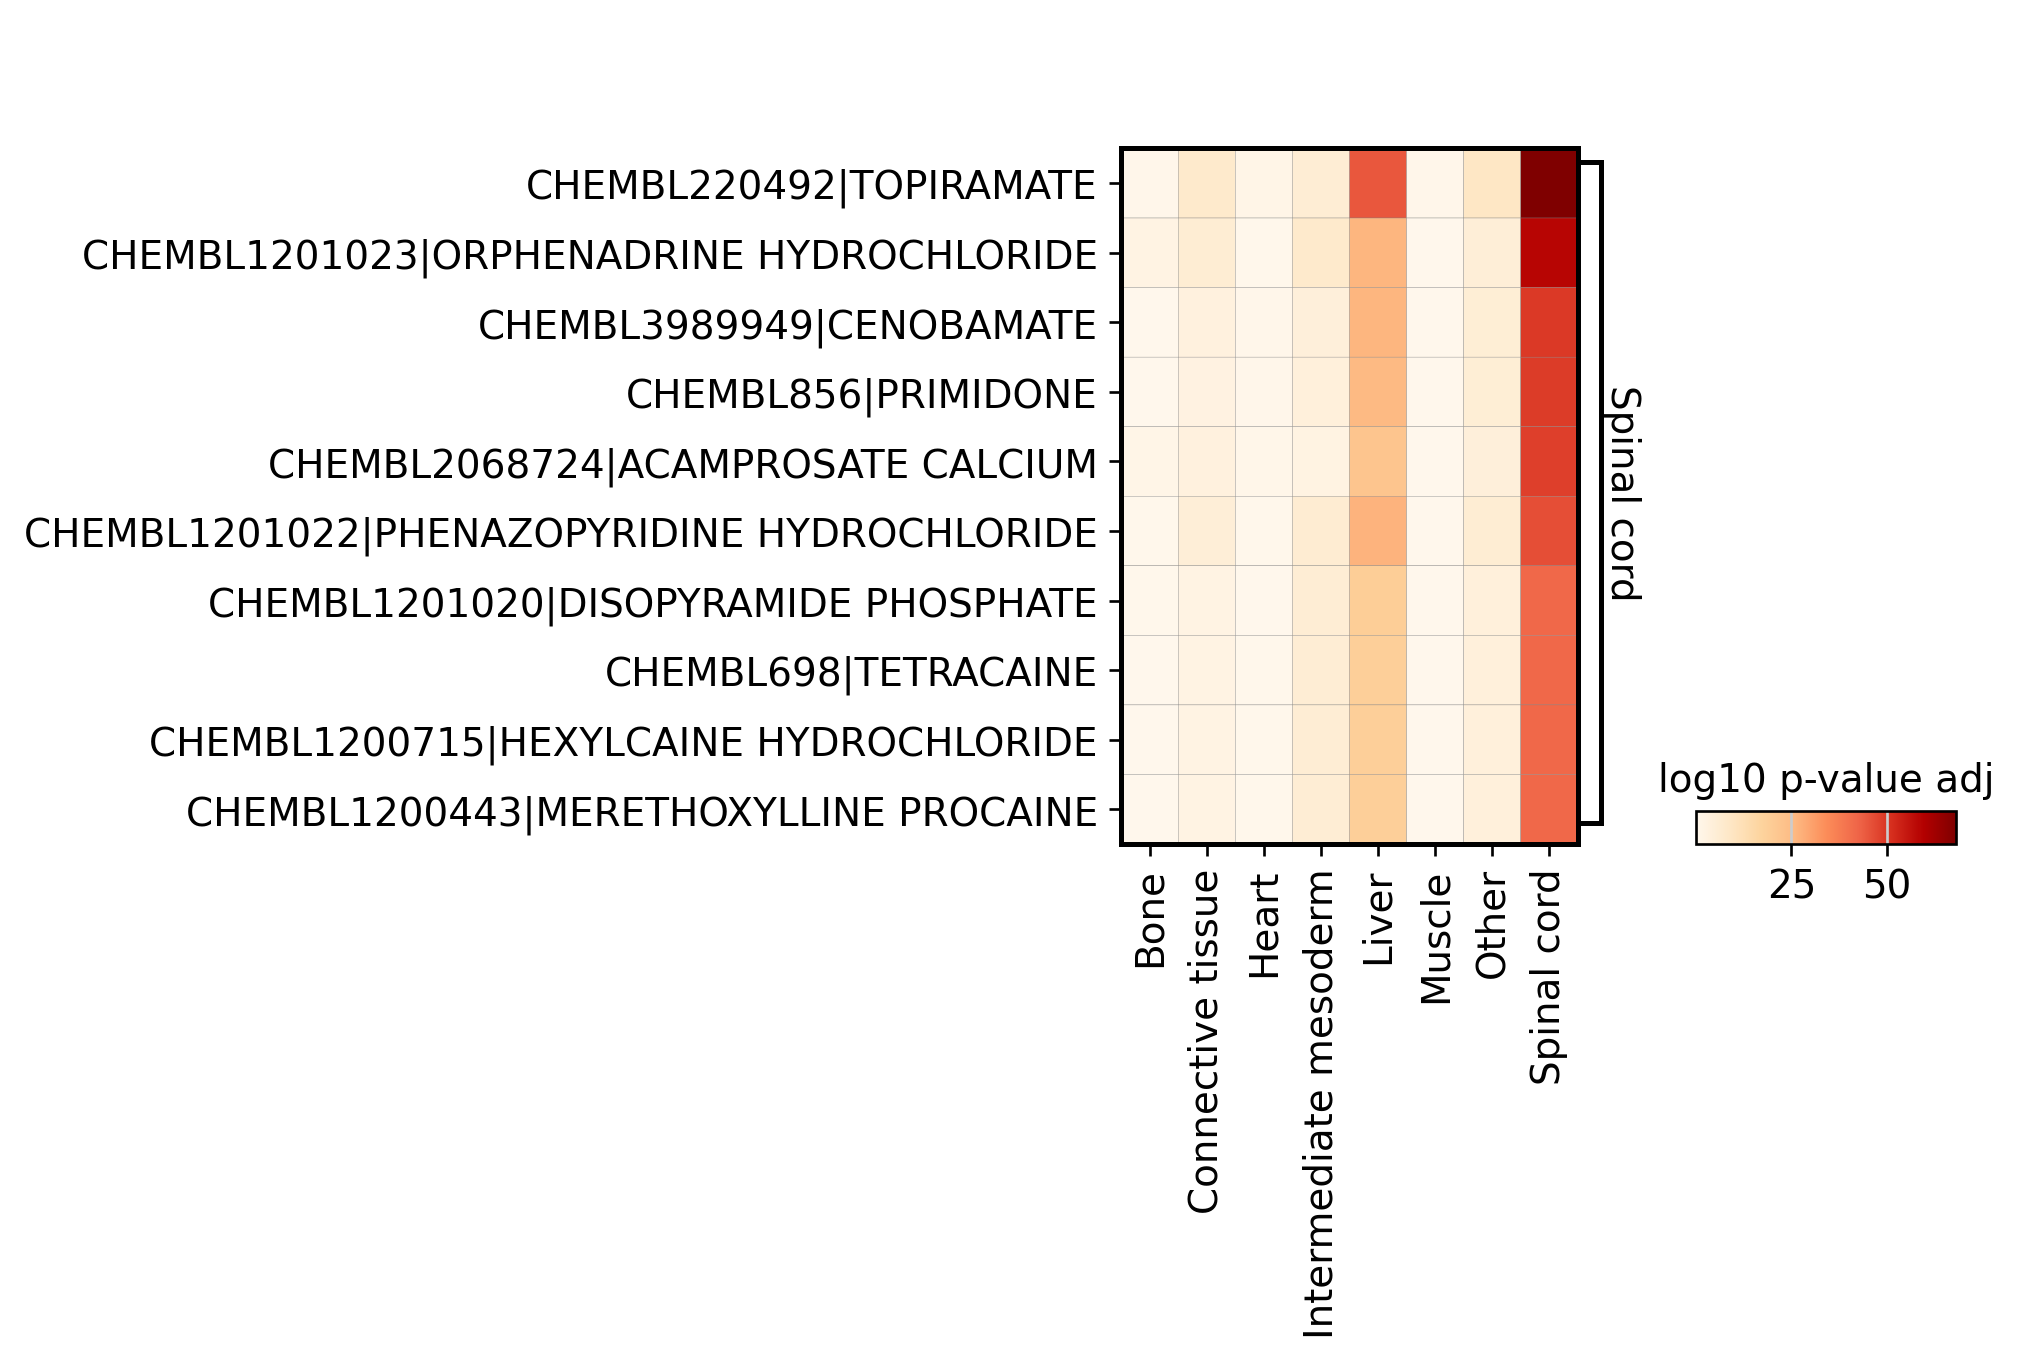

In [79]:
sc.tl.rank_genes_groups(adata.uns['drug2cell_all'], method="wilcoxon", groupby="spatial domain")
sc.pl.rank_genes_groups_matrixplot(adata.uns['drug2cell_all'], dendrogram=False,values_to_plot="log10_pvals_adj", groups=["Spinal cord"], show=True, cmap="OrRd", swap_axes=True)